In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
#train = pd.read_csv('train.csv')
#test = pd.read_csv('test.csv')

In [3]:
for col in ['casual', 'registered', 'count']:
    train['%s_log' % col] = np.log(train[col] + 1)

train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,casual_log,registered_log,count_log
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1.386294,2.639057,2.833213
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2.197225,3.496508,3.713572
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1.791759,3.332205,3.496508
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,1.386294,2.397895,2.639057
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,0.000000,0.693147,0.693147


In [4]:
dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# 纳税日需要工作
train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# 感恩节不需要工作
test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# 圣诞节不需要工作
test.loc[get_day(pd.datetime(2011, 12, 24)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 26)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 31)), "workingday"] = 0

#暴雨
test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#海啸
train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [5]:
from datetime import datetime

def time_process(df):
    df['year'] = pd.DatetimeIndex(df.index).year
    df['month'] = pd.DatetimeIndex(df.index).month
    df['day'] = pd.DatetimeIndex(df.index).day
    df['hour'] = pd.DatetimeIndex(df.index).hour
    df['week'] = pd.DatetimeIndex(df.index).weekofyear
    df['weekday'] = pd.DatetimeIndex(df.index).dayofweek
    return df

train = time_process(train)
test = time_process(test)

<AxesSubplot: xlabel='hour', ylabel='count'>

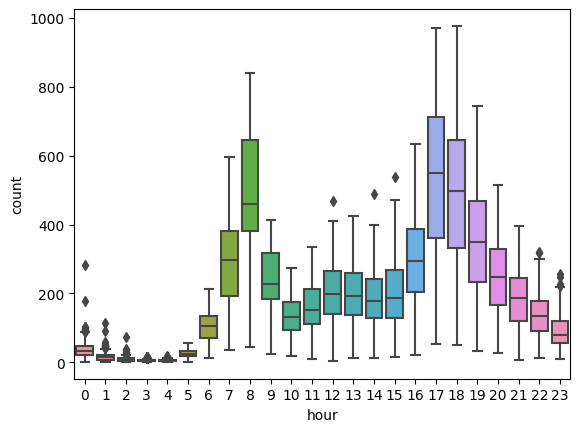

In [6]:
sns.boxplot(x='hour',y='count',data=train[train['workingday'] == 1])

<AxesSubplot: xlabel='hour', ylabel='count'>

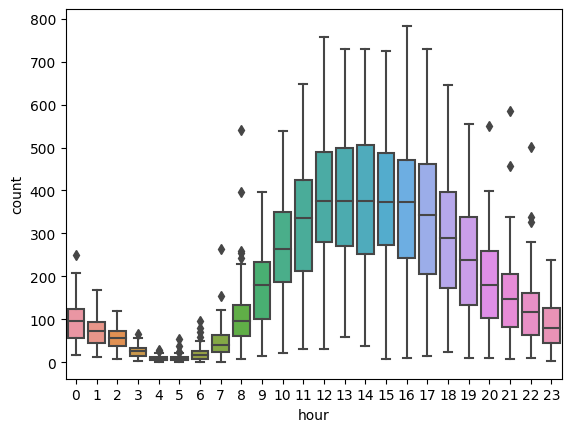

In [7]:
sns.boxplot(x='hour',y='count',data=train[train['workingday'] == 0])

In [8]:
train['peak'] = train[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)
test['peak'] = test[['hour', 'workingday']].apply(lambda x: (0, 1)[(x['workingday'] == 1 and  ( x['hour'] == 8 or 17 <= x['hour'] <= 18  or 12 <= x['hour'] <= 13)) or (x['workingday'] == 0 and  10 <= x['hour'] <= 19)], axis = 1)

<AxesSubplot: >

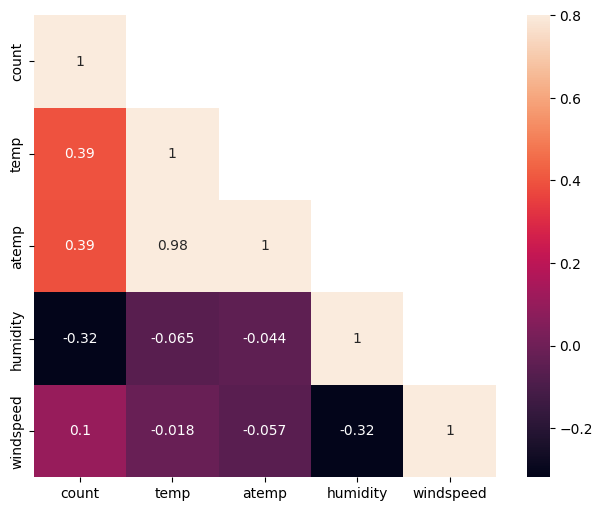

In [19]:
corr = train[['count','temp','atemp','humidity','windspeed']].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(8,6)
sns.heatmap(corr,mask=mask,vmax=.8,square=True,annot=True)

In [10]:
rf_columns = [
    'weather', 'temp', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'week', 'peak',
]
gb_columns =[
    'weather', 'temp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'weekday', 'year', 
]

In [11]:
rf_x_train=train[rf_columns].values
rf_x_test=test[rf_columns].values

gb_x_train=train[gb_columns].values
gb_x_test=test[gb_columns].values

y_casual=train['casual_log'].values
y_registered=train['registered_log'].values
y=train['count_log'].values

x_date=test['datetime'].values

In [12]:
#random forest
from sklearn.ensemble import RandomForestRegressor
params = {'n_estimators': 1000, 
          'max_depth': 15, 
          'random_state': 0, 
          'min_samples_split' : 2, 
          'n_jobs': -1}

rf_c = RandomForestRegressor(**params)
rf_c.fit(rf_x_train,y_casual)
print('casual:',rf_c.score(rf_x_train,y_casual))

rf_r = RandomForestRegressor(**params)
rf_r.fit(rf_x_train,y_registered)
print('registered:',rf_r.score(rf_x_train,y_registered))

casual: 0.9726067525351507
registered: 0.9808557797583348


In [13]:
#xgb
import xgboost as xgb
xgb_c = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, random_state = 0,n_estimators=200)
xgb_c.fit(gb_x_train, y_casual)
print('casual:',xgb_c.score(gb_x_train,y_casual))

xgb_r = xgb.XGBRegressor(max_depth=5, learning_rate=0.1, random_state = 0,n_estimators=200)
xgb_r.fit(gb_x_train, y_registered)
print('registered:',xgb_r.score(gb_x_train,y_registered))

casual: 0.9235170841306428
registered: 0.9712917213282761


In [15]:
from sklearn.ensemble import GradientBoostingRegressor

params2 = {'n_estimators': 150, 
           'max_depth': 5, 
           'random_state': 0, 
           'min_samples_leaf' : 10, 
           'learning_rate': 0.1, 
           'subsample': 0.7, 
           }

gb_c = GradientBoostingRegressor(**params2)
gb_c.fit(gb_x_train,y_casual)
print('casual:',gb_c.score(gb_x_train,y_casual))

gb_r = GradientBoostingRegressor(**params2)
gb_r.fit(gb_x_train,y_registered)
print('registered:',gb_r.score(gb_x_train,y_registered))

casual: 0.9195514835772132
registered: 0.968499680058303


In [17]:
rf_pre_count = np.exp(xgb_c.predict(gb_x_test))+np.exp(rf_r.predict(rf_x_test))-2
xgb_pre_count = np.exp(xgb_c.predict(gb_x_test))+np.exp(xgb_r.predict(gb_x_test))-2

pre_count=np.round(0.2*rf_pre_count+0.8*xgb_pre_count,0)
submit = pd.DataFrame({'datetime':x_date,'count':pre_count})
submit.to_csv('./datasets/submisssion.csv',index=False)